In [1]:
# Importing requird python packages
# Path to hsmpy package
HSMPY_PATH = r'\\CHCFPP01\Guest\MRajabi\Python Scripts'
import sys, os, arcpy, csv, json, math
sys.path.append(HSMPY_PATH)
import hsmpy3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from IPython.display import Image
from IPython.core.display import HTML 
import subprocess 
import webbrowser
import time
import copy
import shutil
from time import gmtime, strftime
print(strftime("%Y-%m-%d %H:%M:%S"))

2019-01-03 11:31:45


In [2]:
# Defining Parameteres
print(strftime("%Y-%m-%d %H:%M:%S"))
Years = range(2005,2017)
MaxOpenProcesses = 15

Project_DIR  = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO19\HSIP_Tracking_Tool'
Project_GDB  = Project_DIR + '\\2.Project_GDB.gdb'
ContractsDir = Project_DIR + '\\4.Contracts_AnalysisFiles'
DocumentsDir = Project_DIR + '\\5.Documents'
PythonDir    = Project_DIR + '\\6.Python_Codes'
ReceivedDir  = Project_DIR + '\\7.ReceivedData'
XML_Dir      = ReceivedDir + '\\HSIP Candidate Applications'


# IRIS Dataset
IRISPath = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\7_BaseData\Master_BaseFiles_Data\5.0_Roadway_Layer\IRIS'
IRISPath = r'C:\Users\mr068144\Downloads\IRIS\IL_IRIS.gdb'
IRIS_Route = {y:os.path.join(IRISPath,'HWY'+str(y)+'_route') for y in Years}
IRIS_Tab   = {y:os.path.join(IRISPath,'HWY'+str(y)+'_table_HCurve') for y in Years}
IRIS_Tab[2012] = IRIS_Tab[2013]

# Intersections Dataset
IntPG = r'C:\Users\mr068144\Downloads\6.0_Intersection_Layer\IRIS_Ints.gdb\Int2014_PG'
Intersections = {year:IntPG for year in Years}

#Crash Dataset
CrashData  = {y:os.path.abspath(r'C:\Users\mr068144\Downloads\IL Crash Data\IL_Crash.gdb\\' +
                          'CrashExtract_' + str(y) + '_GIS') for y in Years}

Fields = ['AADT',
          'O_SHD1_TYP','O_SHD1_WTH','O_SHD2_TYP','O_SHD2_WTH',
          'I_SHD1_TYP','I_SHD1_WTH','I_SHD2_TYP','I_SHD2_WTH',
          'LNS','LN_WTH','MED_TYP','MED_WTH','SURF_WTH','URBAN','PG','Radius','CurveLen']
#Fields = ['AADT','URBAN','PG']
RouteID = 'INVENTORY'
BMP = 'BEG_STA'
EMP = 'END_STA'

# Geocoded projects
HSIP_Int  = Project_GDB + '\\WPPS_Int'
HSIP_Seg  = Project_GDB + '\\WPPS_Seg'

HSIP_Path    = ReceivedDir + '\\HSIP_AllApprovedProjects.xlsm'
WPPS_Ob_Path = ReceivedDir + '\\HSIP Contract and Obligation Data.xlsx'
WPPS_Pr_Path = ReceivedDir + '\\HSIP Project Programmed Data.xlsx'
SPF_Data     = ReceivedDir  + '\\SPF Coefficients.xlsx'

2019-01-03 11:31:45


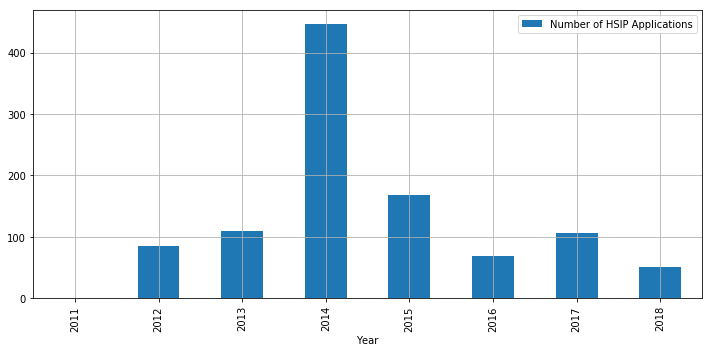

In [31]:
HSIP_Joined = pd.read_excel(DocumentsDir + '\\HSIP_Joined.xlsx')
HSIP_Joined.index = HSIP_Joined.HSIPID
df = pd.DataFrame()
df['Year'] = HSIP_Joined.HSIPID.astype(str).apply(lambda x:x[0:4]).astype(int)
df['Month'] = HSIP_Joined.HSIPID.astype(str).apply(lambda x:x[4:6]).astype(int)
df['Date'] = [datetime(y,m,1) for y,m in zip(df.Year,df.Month)]
df['Date'] = df.Date.apply(lambda x: x.strftime('%Y-%b'))
df = pd.DataFrame(df.groupby("Year").size())
df.plot.bar(figsize=(10,5),label='Number of HSIP Applications')
plt.grid()
plt.legend(['Number of HSIP Applications'])
plt.tight_layout()
plt.savefig('HSIP_ID_By_Year.png')

In [6]:
# HSIP Applications by EA
def Extract_EAs(s,EA):
    try:
        if math.isnan(s):
            return([])
    except:
        s = str(s)
    L_List = s.split(' ')
    ea_List = {ea:False for ea in EA}
    for k in L_List:
        k = k.replace(',','')
        if len(k)<3:
            continue
        for ea in EA:
            if k in ea:
                ea_List[ea] = True
    return([ea for ea in ea_List if ea_List[ea]])
def HSIP_Aggr_EA(HSIP_DF):
    EA = ['RoadDepart',
            'Intersections',
            'DrBehavAwar',
            'LargeTrucks',
            'HwyRRGradeXX',
            'AlcoholRel',
            'InfoSys',
            'WorkZones',
            'BeltsProtection',
            'VulnerUsers']

    Aggr_DF = pd.DataFrame(columns=['Tot','Tot.Awrd.Amount'])
    Index = EA
    for c in Aggr_DF.columns:
        Aggr_DF[c] = [0.0 for ea in EA]
    Aggr_DF.index = Index
    
    for i,r in HSIP_DF.iterrows():
        ea_List = Extract_EAs(r['EmphasisArea'],EA)
        for ea in ea_List:
            Aggr_DF.set_value(ea,'Tot',Aggr_DF.loc[ea]['Tot']+1) 

            if r['ApprAmnt']>0:
                Aggr_DF.set_value(ea,'Tot.Awrd.Amount',Aggr_DF.loc[ea]['Tot.Awrd.Amount']+r['ApprAmnt'])
            
    Aggr_DF.index = Index
    return(Aggr_DF)
def Cont_Aggr_District(Cont_DF):
    Dist = range(1,10)
    Aggr_DF = pd.DataFrame(columns=['Tot','Tot.Awrd.Amount'])
    Index = Dist
    for c in Aggr_DF.columns:
        Aggr_DF[c] = [0.0 for ea in Dist]
    Aggr_DF.index = Index
    
    for i,r in Cont_DF.iterrows():
        ea_List = r['District'].split(';')
        for ea in ea_List:
            Aggr_DF.set_value(int(ea),'Tot',Aggr_DF.loc[int(ea)]['Tot']+1) 

            if r['AwardAmount']>0:
                Aggr_DF.set_value(int(ea),'Tot.Awrd.Amount',Aggr_DF.loc[int(ea)]['Tot.Awrd.Amount']+r['AwardAmount'])
            
    Aggr_DF.index = Index
    return(Aggr_DF)


In [7]:
# Reading Input Data
print(strftime("%Y-%m-%d %H:%M:%S"))
XML_DF     = hsmpy3.il.HSIP_DF_From_XML(XML_Dir)

print(strftime("%Y-%m-%d %H:%M:%S"))
HSIP_DF    = hsmpy3.il.CreateHSIPDataFrame(HSIP_Path,Years)
HSIP_DF = HSIP_DF[[(i in XML_DF.HSIPID) for i in HSIP_DF.index]]

print(strftime("%Y-%m-%d %H:%M:%S"))
WPPS_Ob_DF = hsmpy3.il.HSIP_DF_WPPS_Ob(WPPS_Ob_Path,HSIP_DF,XML_DF)
WPPS_Pr_DF = hsmpy3.il.HSIP_DF_WPPS_Pr(WPPS_Pr_Path,HSIP_DF,XML_DF)

print(strftime("%Y-%m-%d %H:%M:%S"))

HSIP_Joined = hsmpy3.il.Joined_HSIP_DF(XML_DF,HSIP_DF,WPPS_Ob_DF,WPPS_Pr_DF)

print(strftime("%Y-%m-%d %H:%M:%S"))
Cont_DF = hsmpy3.il.Joined_Contract_DF(HSIP_Joined,WPPS_Ob_DF,WPPS_Pr_DF,ReceivedDir,Years)

print(strftime("%Y-%m-%d %H:%M:%S"))
Loc_DF = hsmpy3.il.Joined_Loc_DF(WPPS_Pr_DF)

print(strftime("%Y-%m-%d %H:%M:%S"))
SPF_DF = pd.read_excel(SPF_Data,sheetname='Summary')
SPF_DF['PGNumber'] = [int(s.split('PeerGroup ')[1][:2]) for s in SPF_DF.PG]

PN = list(set(Loc_DF['ContNum']))
PN.sort()

2018-07-23 11:11:15
2018-07-23 11:13:41
2018-07-23 11:13:44
2018-07-23 11:13:49
2018-07-23 11:14:05
2018-07-23 11:14:29
2018-07-23 11:14:29


In [12]:
print(XML_DF.shape)
print('TotalApproved: {:0,.0f}'.format(sum([i for i in HSIP_Joined.ApprAmnt if not math.isnan(i)])))

(1037, 261)
TotalApproved: 884,141,398


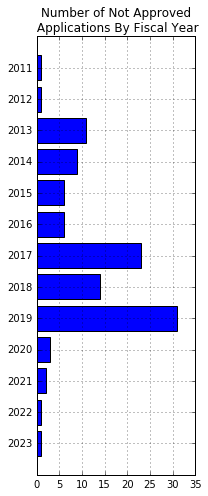

109


In [94]:
# Number of rejected HSIPs by Funding Fiscal Year 
df = HSIP_Joined[HSIP_Joined.ApprAmnt==0] 
S = df.FiscalYear.value_counts()
S = S.sort_index(ascending=False)
FN = DocumentsDir + '\\Not_ Approved_HSIP_By_FY.png'
N = list(S.index)
V = list(S)
labels = N
plt.figure(figsize=(3,7))
plt.barh(range(1,len(N)+1),V,align='center')
plt.yticks(range(1,len(N)+1),labels,rotation=0)
plt.title('Number of Not Approved\n Applications By Fiscal Year')
plt.grid()
plt.tight_layout()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))

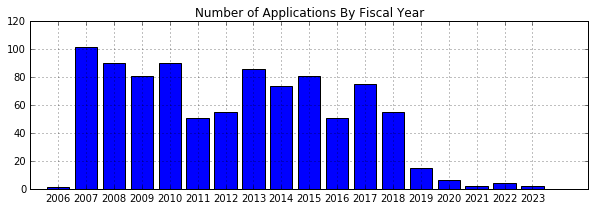

921


In [19]:
# Number of HSIPs by Funding Fiscal Year 
df = HSIP_Joined[HSIP_Joined.ApprAmnt>0] 
S = df.FiscalYear.value_counts()
S = S.sort_index()
FN = DocumentsDir + '\\HSIP_By_FY.png'
S = S.sort_index()
N = list(S.index)
V = list(S)
labels = N
plt.figure(figsize=(10,3))
plt.bar(range(1,len(N)+1),V,align='center')
plt.xticks(range(1,len(N)+1),labels,rotation=0)
plt.title('Number of Applications By Fiscal Year')
plt.grid()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))

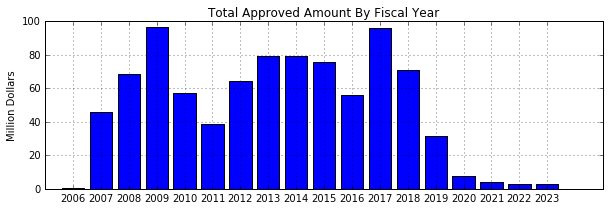

878.532398


In [14]:
# Total ApprAmnt by Funding Fiscal Year 
X = 'FiscalYear'
Y = 'ApprAmnt'
S = df.groupby(X)[Y].sum()
S = S.sort_index()
FN = DocumentsDir + '\\HSIP_App_By_FY.png'
S = S.sort_index()
N = list(S.index)
V = [i/1000000.0 for i in list(S)]
labels = N
plt.figure(figsize=(10,3))
plt.bar(range(1,len(N)+1),V,align='center')
plt.xticks(range(1,len(N)+1),labels,rotation=0)
plt.title('Total Approved Amount By Fiscal Year')
plt.ylabel('Million Dollars')
plt.grid()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))

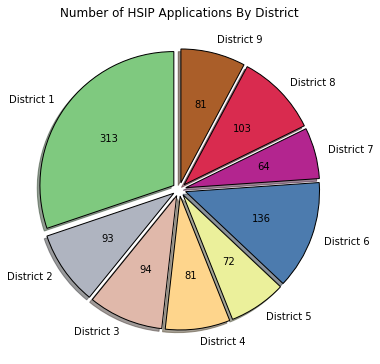

1037


In [28]:
# HSIP Applications By Districts
S = HSIP_Joined.District.value_counts()
FN = DocumentsDir + '\\HSIP_By_District.png'
S = S.sort_index()
N = list(S.index)
V = list(S)
labels = ['District '+ str(i) for i in N]
explode = [0.05 for i in enumerate(V)]
cmap = matplotlib.cm.get_cmap('Accent')
rgba = cmap(np.arange(0,1,1.0/9))
plt.figure(figsize=(6,6))
def absolute_value(val):
    a = int(np.round(val*sum(V)/100.0))
    return a
plt.pie(V,labels=labels,colors=rgba, 
        explode=explode,shadow=True, startangle=90, autopct=absolute_value)
plt.title('Number of HSIP Applications By District')
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))

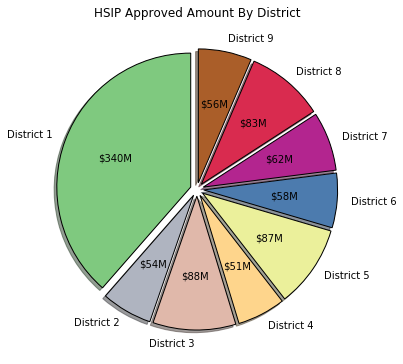

884.141398


In [29]:
# HSIP Applications By Districts
X = 'District'
Y = 'ApprAmnt'
S = HSIP_Joined.groupby(X)[Y].sum()
FN = DocumentsDir + '\\HSIP_Appr_By_District.png'
S = S.sort_index()
N = list(S.index)
V = list(S)
labels = ['District '+ str(i) for i in N]
explode = [0.05 for i in enumerate(V)]
cmap = matplotlib.cm.get_cmap('Accent')
rgba = cmap(np.arange(0,1,1.0/9))
plt.figure(figsize=(6,6))
def absolute_value(val):
    a = int(np.round(val*sum(V)/100.0)/1000000.0)
    return ('${}M'.format(a))

plt.pie(V,labels=labels,colors=rgba, autopct=absolute_value,
        explode=explode,shadow=True, startangle=90)
plt.title('HSIP Approved Amount By District')
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V)/1000000)

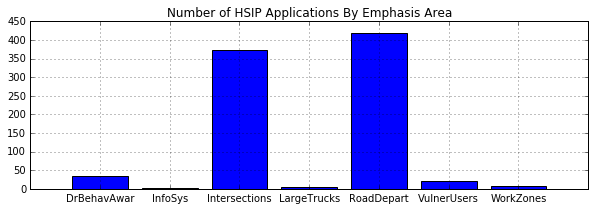

859.0


In [67]:
# Number of HSIPS by EA
df = HSIP_Aggr_EA(HSIP_Joined)
df = df[df.Tot>0]
S = df.Tot
FN = DocumentsDir + '\\HSIP_By_EA.png'
S = S.sort_index()
N = list(S.index)
V = list(S)
labels = N
plt.figure(figsize=(10,3))
plt.bar(range(1,len(N)+1),V,align='center')
plt.xticks(range(1,len(N)+1),N,rotation=0)
plt.title('Number of HSIP Applications By Emphasis Area')
plt.grid()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))

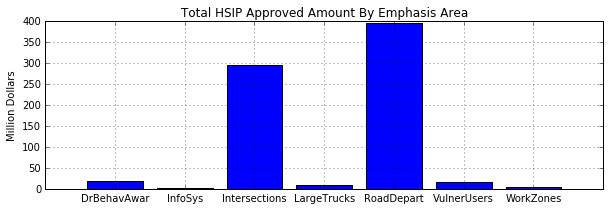

739.827972


In [66]:
# Awarded by EA
df = HSIP_Aggr_EA(HSIP_Joined)
df = df[df['Tot.Awrd.Amount']>0]
S = df['Tot.Awrd.Amount']/1000000.0
FN = DocumentsDir + '\\HSIP_Appr_By_EA.png'
S = S.sort_index()
N = list(S.index)
V = list(S)
labels = N
plt.figure(figsize=(10,3))
plt.bar(range(1,len(N)+1),V,align='center')
plt.xticks(range(1,len(N)+1),N,rotation=0)
plt.title('Total HSIP Approved Amount By Emphasis Area')
plt.ylabel('Million Dollars')
plt.grid()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))

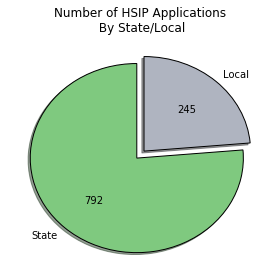

1037


In [99]:
# HSIP Applications By State Local
S = HSIP_Joined.IsLocal.value_counts()
FN = DocumentsDir + '\\HSIP_By_Local.png'
S = S.sort_index()
N = list(S.index)
V = list(S)
labels = [{True:'Local',False:'State'}[i] for i in N]
explode = [0.05 for i in enumerate(V)]
cmap = matplotlib.cm.get_cmap('Accent')
rgba = cmap(np.arange(0,1,1.0/9))
plt.figure(figsize=(4,4))
def absolute_value(val):
    a = int(np.round(val*sum(V)/100.0))
    return a
plt.pie(V,labels=labels,colors=rgba, 
        explode=explode,shadow=True, startangle=90, autopct=absolute_value)
plt.title('Number of HSIP Applications\n By State/Local')
plt.tight_layout()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))

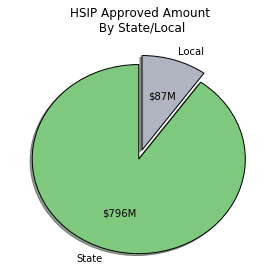

884.141398


In [30]:
# HSIP Applications By State/Local ApprAmnt
X = 'IsLocal'
Y = 'ApprAmnt'
S = HSIP_Joined.groupby(X)[Y].sum()
FN = DocumentsDir + '\\HSIP_Appr_By_Local.png'
S = S.sort_index()
N = list(S.index)
V = list(S)
labels = [{True:'Local',False:'State'}[i] for i in N]
explode = [0.05 for i in enumerate(V)]
cmap = matplotlib.cm.get_cmap('Accent')
rgba = cmap(np.arange(0,1,1.0/9))
plt.figure(figsize=(4,4))
def absolute_value(val):
    a = int(np.round(val*sum(V)/100.0)/1000000.0)
    return ('${}M'.format(a))

plt.pie(V,labels=labels,colors=rgba, autopct=absolute_value,
        explode=explode,shadow=True, startangle=90)
plt.title('HSIP Approved Amount\n By State/Local')
plt.tight_layout()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V)/1000000)

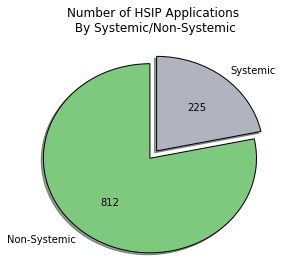

1037


In [101]:
# HSIP Applications By Systemic
S = HSIP_Joined.IsSystemic.value_counts()
FN = DocumentsDir + '\\HSIP_By_Systemic.png'
S = S.sort_index()
N = list(S.index)
V = list(S)
labels = [{True:'Systemic',False:'Non-Systemic'}[i] for i in N]
explode = [0.05 for i in enumerate(V)]
cmap = matplotlib.cm.get_cmap('Accent')
rgba = cmap(np.arange(0,1,1.0/9))
plt.figure(figsize=(4,4))
def absolute_value(val):
    a = int(np.round(val*sum(V)/100.0))
    return a
plt.pie(V,labels=labels,colors=rgba, 
        explode=explode,shadow=True, startangle=90, autopct=absolute_value)
plt.title('Number of HSIP Applications\n By Systemic/Non-Systemic')
plt.tight_layout()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))

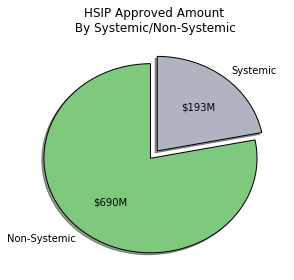

884.141398


In [31]:
# HSIP Applications By Systemic ApprAmnt
X = 'IsSystemic'
Y = 'ApprAmnt'
S = HSIP_Joined.groupby(X)[Y].sum()
FN = DocumentsDir + '\\HSIP_Appr_By_Systemic_Appr.png'
S = S.sort_index()
N = list(S.index)
V = list(S)
labels = [{True:'Systemic',False:'Non-Systemic'}[i] for i in N]
explode = [0.05 for i in enumerate(V)]
cmap = matplotlib.cm.get_cmap('Accent')
rgba = cmap(np.arange(0,1,1.0/9))
plt.figure(figsize=(4,4))
def absolute_value(val):
    a = int(np.round(val*sum(V)/100.0)/1000000.0)
    return ('${}M'.format(a))

plt.pie(V,labels=labels,colors=rgba, autopct=absolute_value,
        explode=explode,shadow=True, startangle=90)
plt.title('HSIP Approved Amount\n By Systemic/Non-Systemic')
plt.tight_layout()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V)/1000000)

In [86]:
Awrd_DF = Cont_DF[(Cont_DF.AwardDate>datetime(2000,1,1)) & 
                  (Cont_DF.AwardAmount>0) 
                ]
Comp_DF = Cont_DF[(Cont_DF.CompletionDate>datetime(2000,1,1)) & 
                  (Cont_DF.AwardDate>datetime(2000,1,1)) & 
                  (Cont_DF.AwardAmount>0) &
                  (Cont_DF.CompletionAmount>0) &
                  (Cont_DF.Status=='C')
                 ]
print(len(Cont_DF),len(Awrd_DF),len(Comp_DF))
print(sum(Awrd_DF.AwardAmount))
print(sum(Comp_DF.CompletionAmount))


905 559 415
541365239.54
348271032.9


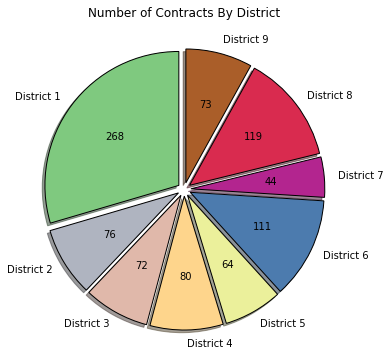

907.0


In [142]:
# Cont Applications By Districts
S = Cont_Aggr_District(Cont_DF)['Tot']
FN = DocumentsDir + '\\Cont_By_District.png'
S = S.sort_index()
N = list(S.index)
V = list(S)
labels = ['District '+ str(i) for i in N]
explode = [0.05 for i in enumerate(V)]
cmap = matplotlib.cm.get_cmap('Accent')
rgba = cmap(np.arange(0,1,1.0/9))
plt.figure(figsize=(6,6))
def absolute_value(val):
    a = int(np.round(val*sum(V)/100.0))
    return a
plt.pie(V,labels=labels,colors=rgba, 
        explode=explode,shadow=True, startangle=90, autopct=absolute_value)
plt.title('Number of Contracts By District')
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))

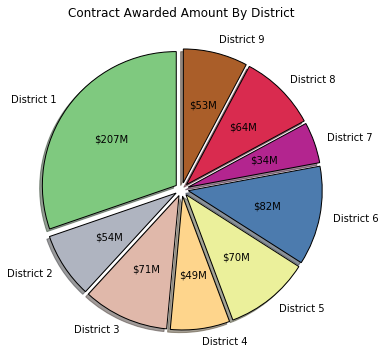

686.86630959


In [32]:
# Cont Applications By Districts
S = Cont_Aggr_District(Cont_DF)['Tot.Awrd.Amount']
FN = DocumentsDir + '\\Cont_By_District_Award.png'
S = S.sort_index()
N = list(S.index)
V = list(S)
labels = ['District '+ str(i) for i in N]
explode = [0.05 for i in enumerate(V)]
cmap = matplotlib.cm.get_cmap('Accent')
rgba = cmap(np.arange(0,1,1.0/9))
plt.figure(figsize=(6,6))
def absolute_value(val):
    a = int(np.round(val*sum(V)/100.0)/1000000)
    return ('${}M'.format(a))
plt.pie(V,labels=labels,colors=rgba, 
        explode=explode,shadow=True, startangle=90, autopct=absolute_value)
plt.title('Contract Awarded Amount By District')
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V)/1000000)

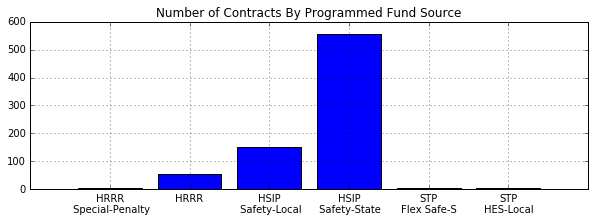

774


In [151]:
df = Cont_DF
S = df.FundSource.value_counts()
S = S[S.index!=""]
FN = DocumentsDir + '\\Cont_By_FundSource_Numbers.png'
S = S.sort_index(ascending=False)
N = list(S.index)
V = list(S)
Dict = {
    'D20':'HSIP\n Safety-State',
    'D21':'HSIP\n Safety-Local',
    'D22':'HRRR'             ,
    'D15':'STP\nFlex Safe-S'  ,
    'D10':'STP\nHES-Local'    ,
    'D28':'HRRR\n Special-Penalty',
    '':' No\n Comp. Amount'
    
}

labels = [Dict[n] for n in N]
#labels.sort()
plt.figure(figsize=(10,3))
plt.bar(range(1,len(N)+1),V,align='center')
plt.xticks(range(1,len(N)+1),labels,rotation=0)
plt.title('Number of Contracts By Programmed Fund Source')
plt.grid()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))

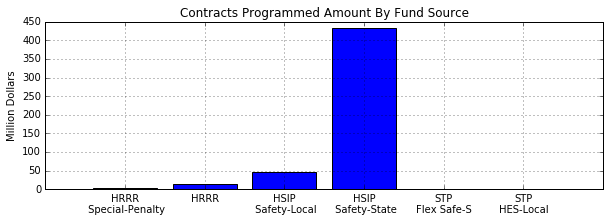

497.93626949


In [152]:
df = pd.DataFrame(columns=[
    'HRRR\n Special-Penalty',
    'HRRR',
    'HSIP\n Safety-Local',
    'HSIP\n Safety-State',
    'STP\nFlex Safe-S',
    'STP\nHES-Local'
])
df.loc[0] = [
    sum(Cont_DF.D28)/1000000.0,
    sum(Cont_DF.D22)/1000000.0,
    sum(Cont_DF.D21)/1000000.0,
    sum(Cont_DF.D20)/1000000.0,
    sum(Cont_DF.D15)/1000000.0,
    sum(Cont_DF.D10)/1000000.0
]
S = df.T[0]
#S = S.sort_index()
FN = DocumentsDir + '\\Cont_By_FundSource.png'
N = list(S.index)
V = list(S)
labels = N
plt.figure(figsize=(10,3))
plt.bar(range(1,len(N)+1),V,align='center')
plt.xticks(range(1,len(N)+1),N,rotation=0)
plt.title('Contracts Programmed Amount By Fund Source')
plt.ylabel('Million Dollars')
plt.grid()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))

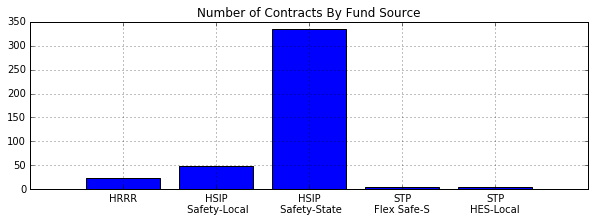

415


In [153]:
df = Comp_DF
S = df.FundSource.value_counts()
FN = DocumentsDir + '\\Comp_By_FundSource_Numbers.png'
S = S.sort_index(ascending=False)
N = list(S.index)
V = list(S)
Dict = {
    'D20':'HSIP\n Safety-State',
    'D21':'HSIP\n Safety-Local',
    'D22':'HRRR'             ,
    'D15':'STP\nFlex Safe-S'  ,
    'D10':'STP\nHES-Local'    ,
    'D28':'HRRR\n Special-Penalty',
    '':' No\n Comp. Amount'
    
}

labels = [Dict[n] for n in N]
plt.figure(figsize=(10,3))
plt.bar(range(1,len(N)+1),V,align='center')
plt.xticks(range(1,len(N)+1),labels,rotation=0)
plt.title('Number of Contracts By Fund Source')
plt.grid()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))

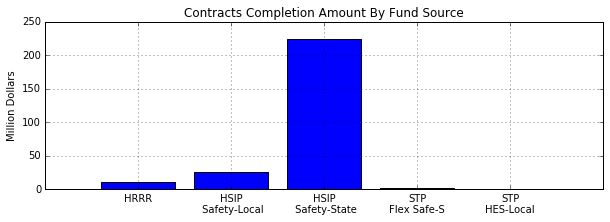

261.74772745


In [154]:
S = pd.Series({
    'HSIP\n Safety-State':sum(Comp_DF.D20)/1000000.0,
    'HSIP\n Safety-Local':sum(Comp_DF.D21)/1000000.0,
    'HRRR'             :sum(Comp_DF.D22)/1000000.0+sum(Comp_DF.D28)/1000000.0,
    'STP\nFlex Safe-S'  :sum(Comp_DF.D15)/1000000.0,
    'STP\nHES-Local'    :sum(Comp_DF.D10)/1000000.0
    
})
FN = DocumentsDir + '\\Comp_By_FundSource.png'
S = S.sort_index()
N = list(S.index)
V = list(S)
labels = N
plt.figure(figsize=(10,3))
plt.bar(range(1,len(N)+1),V,align='center')
plt.xticks(range(1,len(N)+1),N,rotation=0)
plt.title('Contracts Completion Amount By Fund Source')
plt.ylabel('Million Dollars')
plt.grid()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


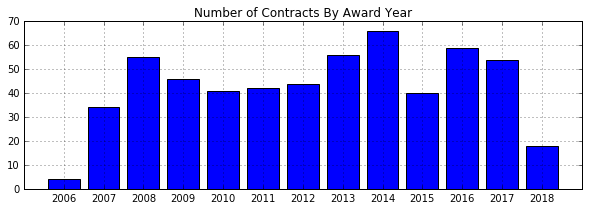

559


In [96]:
# Number of Cont by Program Year 
Awrd_DF['AwardYear'] = [int(i.year) for i in Awrd_DF.AwardDate]
S = Awrd_DF.AwardYear.value_counts()
S = S.sort_index()
FN = DocumentsDir + '\\Cont_By_AwardY.png'
S = S.sort_index()
N = list(S.index)
V = list(S)
labels = N
plt.figure(figsize=(10,3))
plt.bar(range(1,len(N)+1),V,align='center')
plt.xticks(range(1,len(N)+1),labels,rotation=0)
plt.title('Number of Contracts By Award Year')
plt.grid()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


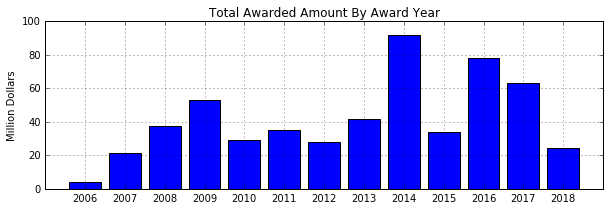

541.36523954


In [98]:
# Total ApprAmnt by Funding Fiscal Year Contracts 
Awrd_DF['AwardYear'] = [int(i.year) for i in Awrd_DF.AwardDate]
X = 'AwardYear'
Y = 'AwardAmount'
S = Awrd_DF.groupby(X)[Y].sum()
S = S.sort_index()
FN = DocumentsDir + '\\Cont_Award_By_AwY.png'
S = S.sort_index()
N = list(S.index)
V = [i/1000000.0 for i in list(S)]
labels = N
plt.figure(figsize=(10,3))
plt.bar(range(1,len(N)+1),V,align='center')
plt.xticks(range(1,len(N)+1),labels,rotation=0)
plt.title('Total Awarded Amount By Award Year')
plt.ylabel('Million Dollars')
plt.grid()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


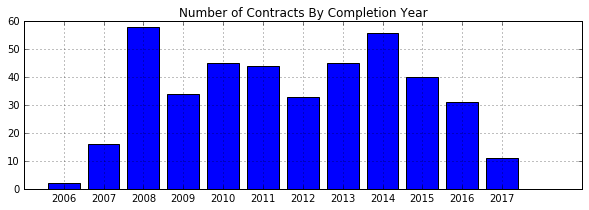

415


In [100]:
# Number of Completed Cont by Program Year 
Comp_DF['CompYear'] = [int(i.year) for i in Comp_DF.CompletionDate]
S = Comp_DF.CompYear.value_counts()
S = S.sort_index()
FN = DocumentsDir + '\\Comp_By_CompY.png'
S = S.sort_index()
N = list(S.index)
V = list(S)
labels = N
plt.figure(figsize=(10,3))
plt.bar(range(1,len(N)+1),V,align='center')
plt.xticks(range(1,len(N)+1),labels,rotation=0)
plt.title('Number of Contracts By Completion Year')
plt.grid()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


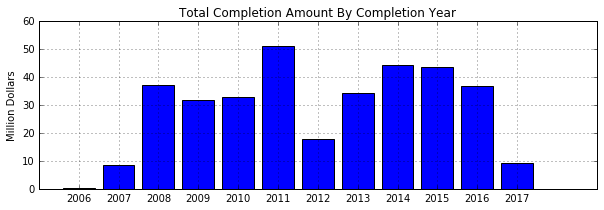

348.2710329


In [101]:
# Total ApprAmnt by Funding Fiscal Year Contracts 
Comp_DF['CompYear'] = [int(i.year) for i in Comp_DF.CompletionDate]
X = 'CompYear'
Y = 'CompletionAmount'
S = Comp_DF.groupby(X)[Y].sum()
S = S.sort_index()
FN = DocumentsDir + '\\Comp_Award_By_AwY.png'
S = S.sort_index()
N = list(S.index)
V = [i/1000000.0 for i in list(S)]
labels = N
plt.figure(figsize=(10,3))
plt.bar(range(1,len(N)+1),V,align='center')
plt.xticks(range(1,len(N)+1),labels,rotation=0)
plt.title('Total Completion Amount By Completion Year')
plt.ylabel('Million Dollars')
plt.grid()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))

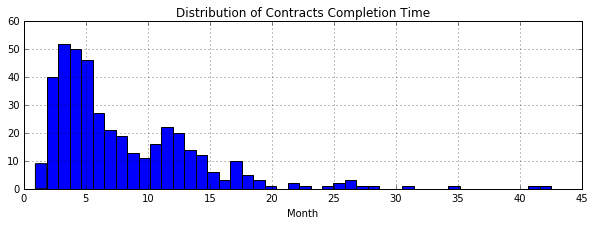

8.02795180723


In [104]:
# Total ApprAmnt by Funding Fiscal Year Contracts 
V = [i.days/30.0 for i in Comp_DF.Duration]
FN = DocumentsDir + '\\Cont_Duration.png'
plt.figure(figsize=(10,3))
plt.hist(V,bins=45)
plt.title('Distribution of Contracts Completion Time')
plt.xlabel('Month')
plt.grid()
plt.savefig(FN,transparent=True)
plt.show()

print(np.mean(V))

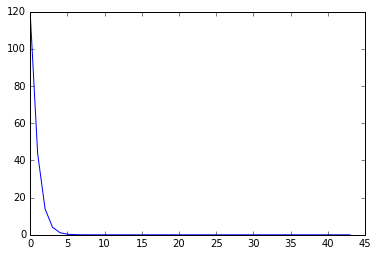

In [67]:
from scipy.stats import nbinom
mu = np.mean(V)
var = np.var(V)
p = (var-mu)/var
r = mu**2/(var-mu)
y = [nbinom.pmf(i, r, p)*len(V) for i in range(1,45)]
plt.plot(y)

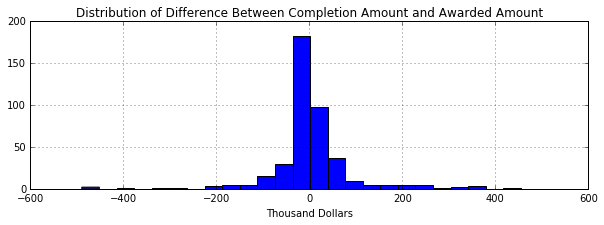

1199.8065399999994


In [102]:
# Total ApprAmnt by Funding Fiscal Year Contracts 
V = [(r.CompletionAmount-r.AwardAmount)/1000 for i,r in Comp_DF.iterrows()]
FN = DocumentsDir + '\\Cont_CompVSAward.png'
plt.figure(figsize=(10,3))
plt.hist(V,bins=25)
plt.title('Distribution of Difference Between Completion Amount and Awarded Amount')
plt.xlabel('Thousand Dollars')
plt.grid()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))

In [157]:
WPPS_Seg_DF = hsmpy3.common.AttributeTabletoDF(r'C:\Users\mr068144\Downloads\Contract_Tracking_Tool\AnalysisDir\WPPS_Geocoded.gdb\WPPS_Seg')

Total Geocoded Contracts: 632
Segs 1165 Mileage 2587.60271482
628459348.79
441552850.02
240493742.36
Total Completed Geocoded Contracts: 358
Segs 544 Mileage 1560.24371186


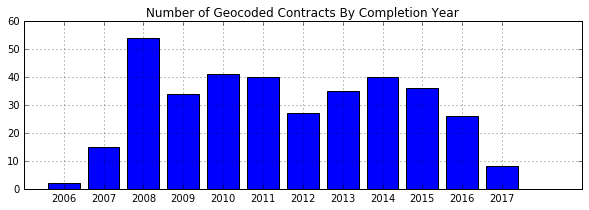

358


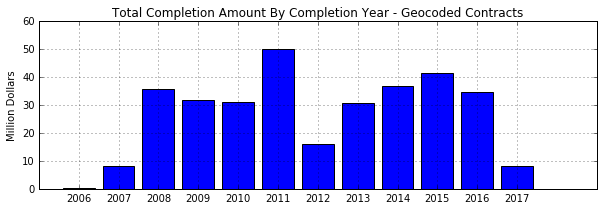

325.40617516


In [184]:
GeoCont = list(WPPS_Seg_DF.ContNum.value_counts().index)
print('Total Geocoded Contracts:',len(GeoCont))
print('Segs',len(WPPS_Seg_DF),'Mileage',sum(WPPS_Seg_DF.Shape_Length)/5280.0)

df = Cont_DF.loc[GeoCont]
print(sum(df.AwardAmount))
print(sum(df.D20)+sum(df.D21)+sum(df.D22)+sum(df.D10)+sum(df.D15)+sum(df.D28))

df = df[(df.CompletionDate>datetime(2000,1,1)) & df.CompletionAmount>0]
print(sum(df.D20)+sum(df.D21)+sum(df.D22)+sum(df.D10)+sum(df.D15)+sum(df.D28))

GeoComp = list(df.ContNum)
WPPS_Index = []
for i in list(WPPS_Seg_DF.index):
    if WPPS_Seg_DF.loc[i]['ContNum'] in GeoComp:
        WPPS_Index.append(i)
df2 = WPPS_Seg_DF.loc[WPPS_Index]
print('Total Completed Geocoded Contracts:',len(GeoComp))
print('Segs',len(df2),'Mileage',sum(df2.Shape_Length)/5280.0)

df['CompYear'] = [int(i.year) for i in df.CompletionDate]
S = df.CompYear.value_counts()
S = S.sort_index()
FN = DocumentsDir + '\\Geo_Comp_By_CompY.png'
S = S.sort_index()
N = list(S.index)
V = list(S)
labels = N
plt.figure(figsize=(10,3))
plt.bar(range(1,len(N)+1),V,align='center')
plt.xticks(range(1,len(N)+1),labels,rotation=0)
plt.title('Number of Geocoded Contracts By Completion Year')
plt.grid()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))


X = 'CompYear'
Y = 'CompletionAmount'
S = df.groupby(X)[Y].sum()
S = S.sort_index()
FN = DocumentsDir + '\\Geo_Comp_By_CmpY.png'
S = S.sort_index()
N = list(S.index)
V = [i/1000000.0 for i in list(S)]
labels = N
plt.figure(figsize=(10,3))
plt.bar(range(1,len(N)+1),V,align='center')
plt.xticks(range(1,len(N)+1),labels,rotation=0)
plt.title('Total Completion Amount By Completion Year - Geocoded Contracts')
plt.ylabel('Million Dollars')
plt.grid()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))


235434586.8
173102123.23


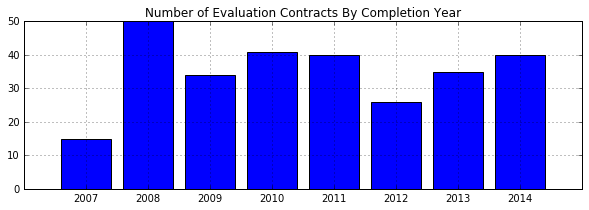

281


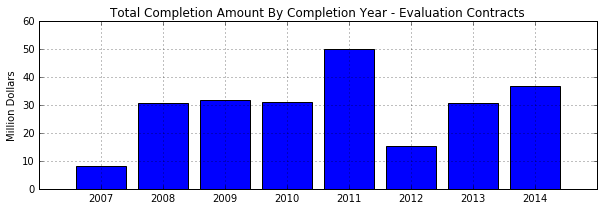

235.4345868


In [186]:
GeoCont = list(WPPS_Seg_DF.ContNum.value_counts().index)

df = Cont_DF.loc[GeoCont]

df = df[(df.AwardDate>=datetime(2007,1,1)) & (df.CompletionDate<datetime(2015,1,1)) & df.CompletionAmount>0]

print(sum(df.CompletionAmount))
print(sum(df.D20)+sum(df.D21)+sum(df.D22)+sum(df.D10)+sum(df.D15)+sum(df.D28))

GeoComp = list(df.ContNum)
WPPS_Index = []
for i in list(WPPS_Seg_DF.index):
    if WPPS_Seg_DF.loc[i]['ContNum'] in GeoComp:
        WPPS_Index.append(i)
df2 = WPPS_Seg_DF.loc[WPPS_Index]

df['CompYear'] = [int(i.year) for i in df.CompletionDate]
S = df.CompYear.value_counts()
S = S.sort_index()
FN = DocumentsDir + '\\Eval_By_CompY.png'
S = S.sort_index()
N = list(S.index)
V = list(S)
labels = N
plt.figure(figsize=(10,3))
plt.bar(range(1,len(N)+1),V,align='center')
plt.xticks(range(1,len(N)+1),labels,rotation=0)
plt.title('Number of Evaluation Contracts By Completion Year')
plt.grid()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))


X = 'CompYear'
Y = 'CompletionAmount'
S = df.groupby(X)[Y].sum()
S = S.sort_index()
FN = DocumentsDir + '\\Eval_By_CmpY_Amount.png'
S = S.sort_index()
N = list(S.index)
V = [i/1000000.0 for i in list(S)]
labels = N
plt.figure(figsize=(10,3))
plt.bar(range(1,len(N)+1),V,align='center')
plt.xticks(range(1,len(N)+1),labels,rotation=0)
plt.title('Total Completion Amount By Completion Year - Evaluation Contracts')
plt.ylabel('Million Dollars')
plt.grid()
plt.savefig(FN,transparent=True)
plt.show()
print(sum(V))
